# Dataset introduction
---
Facial recognition can be broken down into three steps
1. Face detection: Finding the face(s) within an image.
2. Face normalization: Placing the face at the center / resizing to a common size.
3. Face recognition: Who are we looking at / is this the person we want?

[Large Scale Celeb Faces Dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

All data stored in `data/CelebA`, the data in `data/CelebA/Img/img_align_celeba_png` lets us focus
on step 3 (recognition).

The images in these datasets are 218x178, and roughly aligned based on eye position.

Meta data on the images in stored in `data/CelebA/Anno`.

In order to keep things tidy, and be able to reuse functions across notebooks, the majority
of the evaluation functions are stored in `FaceUtilities.py`.

In [1]:
from FaceUtilities import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

### 1. Exploring the dataset
---

#### Images
The `Img` directory contains the full dataset that we are going to use. The faces begin
centered but are not fully detected or blown up to matching dimensions. The dataset is
also pre-split into a training / test set via folders. The `TestImg` folder contains
a subset of the data used in the final evaluation of the models.

#### Preprocessing
A script (`convert_mtcnn.py`) uses a pre-trained CNN to detect the bounding boxes of the first
face in a given image, and then from there I build a new set of images with these faces
stretch into a (224, 224) square. By normalizing the face dimensions throughout, variations in the
face size in the images is reduced, and the background image is removed.  
`Img` $\rightarrow$ `ImgMTC`  
`TestImg` $\rightarrow$ `TestMTC`  
For completeness, the library is available through pip: `pip install mtcnn`

Below is an example of the transformation applied to one of the input images. On the left is the original
face in the dataset, and on the right is the transformed face after cutting the dimensions to fit within
the bounding box found by `mtcnn` and then stretched to fit (224, 224).

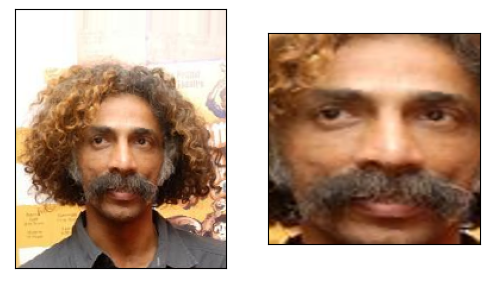

In [2]:
visage = FaceUtilities()

def draw_image_pair(face_id):
    fig, ax = plt.subplots(1, 2, figsize=(6,4))
    ax[0].imshow(keras.utils.load_img(f'{visage.data_directory}/Img/{face_id:06}.png'))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(keras.utils.load_img(f'{visage.data_directory}/ImgMTC/{face_id:06}.png'))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    plt.show()

#dataset = ([fname for fname in os.listdir(f'{model_builder.data_directory}/ImgMTC') if fname.endswith(".png")])
#print(f'Total Images: {len(dataset)}')

draw_image_pair(11111)

### 2. Creating a dataframe matching files to attributes 
---
There are a series of text files in `Anno` that can act as labels for the dataset. `identity_CelebA.txt`
matches each image with a unique identifier, while `list_attr_celeba.txt` contains attributes about
the photos. For facial recognition I'm not necessarily interested in the attributes, though they
could be useful later in associating the feature vector with human identified attributes.

For this analysis I won't be using these labels, as I'm more interested in seeing how the discovered
features can be used to identify faces as opposed to matching features with labels.

In [3]:
'''
`set_directory` is called to build the dataframe for the labels and attributes.
In the process, it removes entries that do not exist within the given directory.
The data is stored in FaceUtilities::labels
'''
visage.set_directory('data/CelebA/ImgMTC/')
print(f'Labels shape: {visage.labels.shape}')
visage.labels.head()

Labels shape: (129335, 44)


,index,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Unnamed: 41,pid
0,0,data/CelebA/ImgMTC/000001.png,-1,1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,1,-1,-1,1,NaN,2880
1,3,data/CelebA/ImgMTC/000004.png,-1,-1,1,-1,-1,-1,-1,-1,...,1,-1,1,-1,1,1,-1,1,NaN,5805
2,4,data/CelebA/ImgMTC/000005.png,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,1,-1,-1,1,NaN,9295
3,6,data/CelebA/ImgMTC/000007.png,1,-1,1,1,-1,-1,1,1,...,1,-1,-1,-1,-1,-1,-1,1,NaN,9040
4,8,data/CelebA/ImgMTC/000009.png,-1,1,1,-1,-1,1,1,-1,...,-1,-1,1,-1,1,-1,-1,1,NaN,3332


### 3. Face recognition model
---

For this trial model we will look to train an embeded features vector (and later compare with
a pre-trained network). The overarching model will contain three copies of this embedded model,
which get compared with one another via pre-defined image triplets.

On each pass through, the embedded network looks at a face and applies a series of convolutional layers
ending in a dense layer of "features". To construct a loss function for the network to learn from,
there will be three of these embedded networks that share weights, and each will be given a different image.
The first will be given the target person (called the anchor image). The second is another image of the same
person, while the third is an image of a different person. The goal of the minimization function is to
train the embedded network in such a way that the distance between the anchor and the positive image is
as small as possible, while simultaneously maximizing the distance between the anchor and the negative
image.

The function `create_or_load_frames` is used to form the (positive, negative) image pairs from the
training folder. The results of these pairings is then stored in `csv` files as a cache to be read
from when the notebook is rerun.

To complete the triplet, negative images are assigned to each of these (positive, negative) pairs
randomly. This method is not the best, as many of the training examples will start with a very large
difference between the anchor and the negative image -- teaching the network very little. This could
be improved by selecting triplets ahead of time where the negative images already closely match
the anchor (or even recreating the triplets after each epoch and making this selection). For this
excercise, that would be too computationally intensive.

In [4]:
# Data pipeline
def create_or_load_frames( base_frame, rewrite=False ):
    '''
    Sets up the anchor and positive image dataframes. Since this is a bit slow, we
    optionally cache to file and load from there unless explicitly asked to recache.
    
    This function lazily splits the dataset in two, then creates matching pairs on
    both sides and removes the rest. A greedy algorithm would provide a larger dataset.
    '''
    anchor_file = 'anchor.csv'
    positive_file = 'positive.csv'
    anchor_frame = None
    positive_frame = None
    if os.path.exists(anchor_file) and os.path.exists(positive_file) and not rewrite:
        anchor_frame = pd.read_csv(anchor_file)
        positive_frame = pd.read_csv(positive_file)
    else:
        split_x = base_frame.shape[0] // 2
    
        anchor_frame = base_frame[:split_x]
        positive_frame = base_frame[split_x:]
        
        persons = np.concatenate([anchor_frame.pid.unique(), positive_frame.pid.unique()])
        anchor_frame = anchor_frame.sort_values('pid')
        positive_frame = positive_frame.sort_values('pid')
        
        for person in persons:
            anchor_count = sum(anchor_frame.pid == person)
            positive_count = sum(positive_frame.pid == person)
            max_entries = min(anchor_count, positive_count)
            if anchor_count > positive_count:
                anchor_frame.drop(index=anchor_frame[anchor_frame.pid == person].index[max_entries:], inplace=True)
            elif positive_count > anchor_count:
                positive_frame.drop(index=positive_frame[positive_frame.pid == person].index[max_entries:], inplace=True)
        anchor_frame.to_csv(anchor_file)
        positive_frame.to_csv(positive_file)
    return anchor_frame, positive_frame

anchor_frame, positive_frame = create_or_load_frames( visage.labels, rewrite=False )

### 4. Data preparation
---
The dataset is split 80/20 into training / validation. Note that an additional ~20% was pre-separated
for test data (so we have three datasets). It would not be possible to load all of the images prior to
insertion into the network given their size and quantity, so instead they will be generated in batches
of 16 triplets through a `triplet_generator` that loads the images into numpy arrays to be fed into the
network. The dataset negative images are a random shuffling of the original dataset, and the `full_dataset`
is then constructed by zipping the `anchor`, `positive`, and `negative` image files together.

In [5]:
# Setup generator / processor
def load_image(filename):
    image = keras.utils.img_to_array(keras.utils.load_img(filename))
    return image

def triplet_generator(anchor, positive, negative):
    return ( 
        np.array([load_image(anchor_img) for anchor_img in anchor]), 
        np.array([load_image(positive_img) for positive_img in positive]), 
        np.array([load_image(negative_img) for negative_img in negative]) 
    ), np.zeros(anchor.shape)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_frame.filename)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_frame.filename)

negative_dataset = tf.data.Dataset.from_tensor_slices(visage.labels.filename)
negative_dataset = negative_dataset.shuffle(4096)

full_dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
full_dataset = full_dataset.shuffle(4096)

# split into training and validation
image_count = anchor_frame.shape[0]
training_ds = full_dataset.take(round(image_count * 0.8))
val_ds = full_dataset.skip(round(image_count * 0.8))

training_ds = training_ds.batch(visage.batch_size, drop_remainder=False)
training_ds = training_ds.prefetch(8)

val_ds = val_ds.batch(visage.batch_size, drop_remainder=False)
val_ds = val_ds.prefetch(8)

As a sanity check, lets take a look at a few of the triplets formed directly in the training set. The first two images in each of the rows should be the same person, and the third is a random test person.

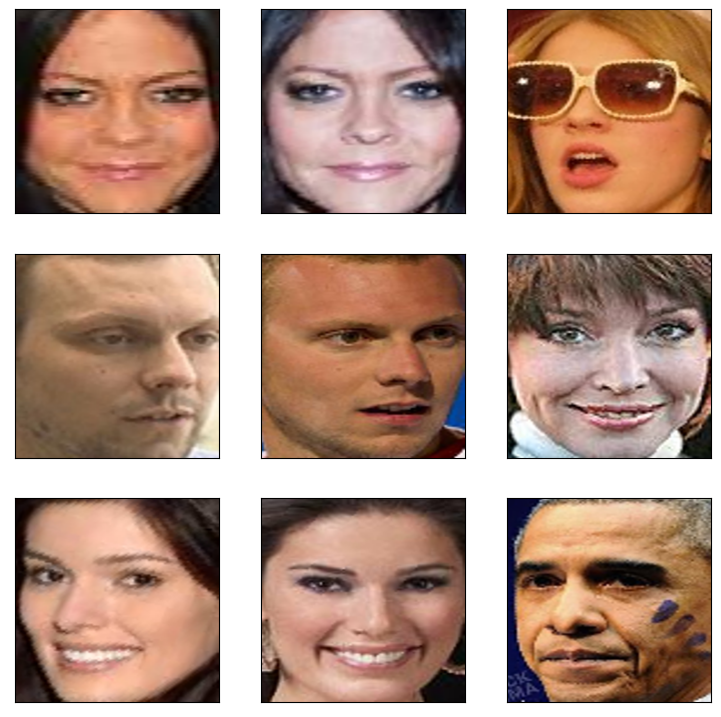

In [6]:
def visualize(anchor, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(9,9))
    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], keras.utils.load_img(anchor[i]))
        show(axs[i, 1], keras.utils.load_img(positive[i]))
        show(axs[i, 2], keras.utils.load_img(negative[i]))
        
visualize(*list(training_ds.take(1).as_numpy_iterator())[0])

### 5. Network and loss function
---
The embedded model is constructed of sets of convolutional layers with max pooling,
normalization, and dropout applied throughout. Each convolutional network has an increased
output dimension, selecting for larger scale features. At the end the model is set to
output 128 normalized parameters that we hope will select for various features in a given image.

As previously discussed, the loss function needs to minimize the distance between anchor and positive,
while maximizing the distance between anchor and negative. To avoid the trivial solution (all features
set to 0), a margin term is added to the loss function that will pull the weights away from this solution.
The loss function is applied based on the three images given in order: anchor, positive, negative 
($\vec{a}$, $\vec{p}$, $\vec{n}$). Included is a margin $\alpha$
$$
    \mathrm{Loss} = ||\vec{a} - \vec{p}|| - ||\vec{a} - \vec{n}|| + \alpha
$$

In [7]:
def define_model( **hyper_parameters ):
    dropout = hyper_parameters.get("dropout", 0.5)
    model = keras.models.Sequential()
    # Conv 1
    model.add( layers.Conv2D(3, (7,7), activation='relu', padding='same', input_shape=(visage.img_height, visage.img_width, 3)) )
    model.add( layers.MaxPooling2D((2,2), padding='same') )
    model.add( layers.BatchNormalization() )
    model.add( layers.Dropout(dropout) )
    # Conv 2
    model.add( layers.Conv2D(64, (1,1), activation='relu', padding='same' ))
    model.add( layers.Conv2D(64, (3,3), activation='relu', padding='same' ))
    model.add( layers.MaxPooling2D((2,2), padding='same') )
    model.add( layers.BatchNormalization() )
    model.add( layers.Dropout(dropout) )
    # Conv 3
    model.add( layers.Conv2D(192, (1,1), activation='relu', padding='same' ))
    model.add( layers.Conv2D(192, (3,3), activation='relu', padding='same' ))
    model.add( layers.MaxPooling2D((2,2), padding='same') )
    model.add( layers.BatchNormalization() )
    model.add( layers.Dropout(dropout) )
    # Conv 4
    model.add( layers.Conv2D(384, (1,1), activation='relu', padding='same' ))
    model.add( layers.Conv2D(384, (3,3), activation='relu', padding='same' ))
    model.add( layers.MaxPooling2D((2,2), padding='same') )
    model.add( layers.BatchNormalization() )
    model.add( layers.Dropout(dropout) )
    # Conv 4
    model.add( layers.Conv2D(256, (1,1), activation='relu', padding='same' ))
    model.add( layers.Conv2D(256, (3,3), activation='relu', padding='same' ))
    model.add( layers.MaxPooling2D((2,2), padding='same') )
    model.add( layers.BatchNormalization() )
    model.add( layers.Dropout(dropout) )
    # ... Create feature vector
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    return model

def loss_function(input_features):
    '''
    Triplet loss function, comparing an anchor, positive, and negative image.
    '''
    anchor, positive, negative = input_features
    margin = 0.5
    positive_difference = tf.sqrt(tf.reduce_sum( tf.square(anchor-positive), 1, keepdims=True ))
    negative_difference = tf.sqrt(tf.reduce_sum( tf.square(anchor-negative), 1, keepdims=True ))
    loss_value = tf.maximum(positive_difference - negative_difference + margin, 0)
    return loss_value

visage.model = define_model()
visage.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       444       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 3)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 3)      12        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      256       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      3

#### Full Model
The embedded model created above is what we are ultimately interested in, but it is designed to only operate
on a single image. To create the full network that keras can train, we need to create an outer model that
passes the three images through the embedded model. Given here as the three Input layers: `anchor_input`,
`positive_input`, and `negative_input`. Each of these is then encoded with the embedded feature model
to produce feature vectors, this is then fed into a Lambda layer that contains the loss function defined
above, which calculates the various distances. This model ultimately computes a single number, which we
then aim to minimize through training.

In [9]:
anchor_input = layers.Input((visage.img_height, visage.img_width, 3), name="anchor_input")
positive_input = layers.Input((visage.img_height, visage.img_width, 3), name="positive_input")
negative_input = layers.Input((visage.img_height, visage.img_width, 3), name="negative_input")

encoded_anchor = visage.model(anchor_input)
encoded_positive = visage.model(positive_input)
encoded_negative = visage.model(negative_input)

inputs = [anchor_input, positive_input, negative_input]
outputs = [encoded_anchor, encoded_positive, encoded_negative]

distance = layers.Lambda(loss_function)(outputs)
train_model = keras.Model(inputs=inputs, outputs=distance)

train_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                            

### 6. Model Training
---
A generator `batch_gen` feeds the batches of 16 images each into the network, and given
the large number of images, I have it setup to take around 4 epochs before the generator
resets back to the beginning of the image bunch.

The model is saved to `p2model` so that it can be loaded and compared with a pre-trained
model in the next two notebooks. The first notebook shows the results using VGGFace, while
the second uses this model.

In [10]:
def batch_gen(ds):
    index = 0
    iterator = ds.as_numpy_iterator()
    while True:
        try:
            step = next(iterator)
            yield triplet_generator(*step)
        except StopIteration:
            iterator = ds.as_numpy_iterator()
            step = next(iterator)
            yield triplet_generator(*step)

num_samples = anchor_frame.shape[0]
steps_per_epoch = num_samples // visage.batch_size // 4
train_xy = batch_gen(training_ds)
valid_xy = batch_gen(val_ds)
train_model.compile(optimizer='adam', loss='mae')
es = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=1e-5)
history = train_model.fit(train_xy, epochs=100, steps_per_epoch = steps_per_epoch, callbacks=[es], 
                          validation_data=valid_xy, validation_steps=10)

Epoch 1/100
712/712 [==============================] - 405s 555ms/step - loss: 0.3217 - val_loss: 0.3127
Epoch 2/100
712/712 [==============================] - 388s 546ms/step - loss: 0.2589 - val_loss: 0.3148
Epoch 3/100
712/712 [==============================] - 299s 420ms/step - loss: 0.2484 - val_loss: 0.2946
Epoch 4/100
712/712 [==============================] - 174s 244ms/step - loss: 0.2357 - val_loss: 0.2906
Epoch 5/100
712/712 [==============================] - 150s 211ms/step - loss: 0.2163 - val_loss: 0.3176
Epoch 6/100
712/712 [==============================] - 150s 210ms/step - loss: 0.2205 - val_loss: 0.2865
Epoch 7/100
712/712 [==============================] - 154s 216ms/step - loss: 0.2135 - val_loss: 0.3072
Epoch 8/100
712/712 [==============================] - 152s 214ms/step - loss: 0.2016 - val_loss: 0.2888
Epoch 9/100
712/712 [==============================] - 159s 223ms/step - loss: 0.1961 - val_loss: 0.2773
Epoch 10/100
712/712 [==============================] -

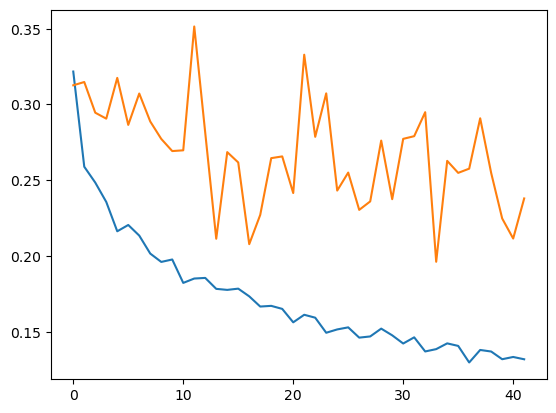

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [13]:
visage.model.save("p2model")

INFO:tensorflow:Assets written to: p2model/assets


INFO:tensorflow:Assets written to: p2model/assets
